Coisas pra fazer:
- Voltar no tratamento de outliers e mudar a forma (estou fazendo com média)
- Voltar na parte que excluo colunas com suporte muito baixo, talvez colocar esses casos para uma coluna "outro"
- Transformar as colunas não numéricas em numéricas
- Ver como selecionar as dimensões
- Ver quais métodos seriam mais adequados
- Como medir os resultados

# Agrupamento

---
Vamos continuar aqui a analisar a base de dados apresentada no Trabalho 2.
Neste caso, vamos gerar e analisar agrupamentos das postagens.

Para esta análise, retirar os seguintes atributos:
- likes
- num_comments
- video_view_count

Para isso:

(1) Gerar grupos utilizando ao menos 2 modelos.
      Não esquecer de fazer os tratamentos adequados nos dados e escolher os parâmetros dos modelos. Especificamente, deve-se justificar o número de grupos escolhido.

(2) Comparar ao menos 2 estratégias de agrupamento.
      Nesta etapa, deve-se comparar os resultados alcançados pelos modelos da etapa (1) via avaliação intrínseca.

(3) Analisar os grupos gerados pelo melhor modelo obtido. Ao resolver o problema descrito em (1) e selecionar o melhor resultado em (2), pode-se agora avaliar esse resultado em termos de análise dos grupos gerados.Por exemplo,
   - quais as principais características dos grupos gerados?
  - há alguma relação desses grupos com os atributos removidos (likes, num_comments e video_view_count)?

<br>Assim como anteriormente, incluam a apresentação/slides (preferencialmente, por conta da duração) ou notebooks como resposta a este trabalho. As apresentações (em sala) devem ter duração máxima de 20min.

In [91]:
from itertools import count

import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, dbscan, KMeans, spectral_clustering, SpectralClustering
import numpy as np
from utils import *
from pyclustertend import hopkins
from kmodes.kprototypes import KPrototypes

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score



# 1. Tratamento dos dados

In [92]:
def binarize_categorical_columns(df, columns):
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df.drop(column, axis=1, inplace=True)
    return df

In [93]:
df = pd.read_csv('preprocessing_result1.csv')
df.drop(columns=['likes','num_comments'], inplace=True)
df = binarize_categorical_columns(df, ['content_type', 'tone', 'emotion_displayed', 'location_type'])
df.dtypes

followers                float64
has_a_person             float64
vape_present             float64
is_vaping                float64
img_mentions_brands      float64
                          ...   
location_type_Indoor        bool
location_type_Neutral       bool
location_type_Outdoor       bool
location_type_Private       bool
location_type_Public        bool
Length: 106, dtype: object

In [94]:
cols_to_booleans = ['target_demographic_Black community',
 'target_demographic_adults',
 'target_demographic_teenagers',
 'target_demographic_young adults',
 'target_demographic_general audience',
 'post_style_array_Inspirational',
 'post_style_array_Informational',
 'post_style_array_Promotion',
 'post_style_array_Announcement',
'has_a_person', 'vape_present', 'is_vaping', 'img_mentions_brands',
'text_mentions_brands',
'Health_ad',
 'are_there_children',
 'sensitive_content_bool',
'type_of_content_array_Initiative',
 'type_of_content_array_Advertisement',
 'type_of_content_array_Promotion',
 'type_of_content_array_Health',
 'type_of_content_array_Campaign',
 'type_of_content_array_Informational',
 'type_of_content_array_Warning'
]

# make all columns booleans
for column in cols_to_booleans:
   if df[column].dtype == 'float64':
       df[column] = df[column].astype('bool')
df

,followers,has_a_person,vape_present,is_vaping,img_mentions_brands,text_mentions_brands,Health_ad,are_there_children,sensitive_content_bool,video_link_count,...,emotion_displayed_supportive,emotion_displayed_surprise,emotion_displayed_thoughtful,emotion_displayed_tired,location_type_Commercial,location_type_Indoor,location_type_Neutral,location_type_Outdoor,location_type_Private,location_type_Public
0,0.668284,False,True,False,True,True,True,False,False,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0.058955,False,False,False,False,False,True,False,False,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0.891045,False,False,False,False,False,True,False,False,0.0,...,False,False,False,False,False,True,False,False,False,False
3,0.002985,True,True,True,False,False,False,False,False,0.0,...,False,False,False,False,False,True,False,False,False,False
4,0.118284,False,False,False,False,False,True,False,False,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.067910,False,False,False,False,False,True,False,False,0.0,...,False,False,False,False,False,False,False,False,False,True
979,0.972761,True,False,False,True,True,True,False,False,0.0,...,False,False,False,False,False,False,False,False,False,True
980,0.003731,True,False,False,False,False,True,False,False,0.0,...,False,False,False,False,False,False,False,False,False,True
981,0.194030,True,False,False,False,False,False,False,False,0.0,...,False,False,False,False,False,False,False,True,False,False


In [95]:
df.columns.tolist()

['followers',
 'has_a_person',
 'vape_present',
 'is_vaping',
 'img_mentions_brands',
 'text_mentions_brands',
 'Health_ad',
 'are_there_children',
 'sensitive_content_bool',
 'video_link_count',
 'people_gender_Female',
 'people_gender_Other',
 'people_gender_Male',
 'people_skin_color_dark',
 'people_skin_color_light',
 'people_skin_color_medium',
 'people_age_group_Young',
 'people_age_group_Teen',
 'people_age_group_Old',
 'people_age_group_Adult',
 'people_physical_attributes_muscular',
 'people_physical_attributes_average',
 'people_common_appearances_sporty',
 'people_common_appearances_professional',
 'people_common_appearances_casual',
 'people_common_appearances_formal',
 'people_hair_color_brown',
 'people_hair_color_grey',
 'people_hair_color_blonde',
 'people_hair_color_red',
 'people_hair_color_white',
 'people_hair_color_other',
 'people_hair_color_black',
 'target_demographic_Black community',
 'target_demographic_adults',
 'target_demographic_teenagers',
 'target_demog

In [96]:
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()

support_df = pd.DataFrame(df[bool_cols].sum(), columns=['counts'])
support_df['support'] = (support_df['counts'] / len(df)) * 100
cols_to_drop = support_df[support_df['support'] < 5].index.tolist()
cols_to_drop

['are_there_children',
 'target_demographic_Black community',
 'post_style_array_Inspirational',
 'type_of_content_array_Initiative',
 'content_type_Reel',
 'content_type_Video',
 'tone_Sarcastic',
 'emotion_displayed_alarm',
 'emotion_displayed_amusement',
 'emotion_displayed_annoyance',
 'emotion_displayed_anxiety',
 'emotion_displayed_approval',
 'emotion_displayed_calm',
 'emotion_displayed_calmness',
 'emotion_displayed_concern',
 'emotion_displayed_confidence',
 'emotion_displayed_contemplation',
 'emotion_displayed_contemplative',
 'emotion_displayed_contentment',
 'emotion_displayed_curiosity',
 'emotion_displayed_determination',
 'emotion_displayed_disapproval',
 'emotion_displayed_displeasure',
 'emotion_displayed_distress',
 'emotion_displayed_engagement',
 'emotion_displayed_excitement',
 'emotion_displayed_focused',
 'emotion_displayed_frustration',
 'emotion_displayed_grumpiness',
 'emotion_displayed_humor',
 'emotion_displayed_intensity',
 'emotion_displayed_motivation',

In [97]:
df.drop(cols_to_drop, axis=1, inplace=True)
df

,followers,has_a_person,vape_present,is_vaping,img_mentions_brands,text_mentions_brands,Health_ad,sensitive_content_bool,video_link_count,people_gender_Female,...,content_type_Carousel,content_type_Image,tone_Negative,tone_Neutral,tone_Positive,emotion_displayed_happiness,emotion_displayed_other,location_type_Indoor,location_type_Outdoor,location_type_Public
0,0.668284,False,True,False,True,True,True,False,0.0,0.00,...,False,True,True,False,False,False,True,False,False,True
1,0.058955,False,False,False,False,False,True,False,0.0,0.00,...,False,True,True,False,False,False,True,False,False,True
2,0.891045,False,False,False,False,False,True,False,0.0,0.00,...,False,True,True,False,False,False,True,True,False,False
3,0.002985,True,True,True,False,False,False,False,0.0,0.25,...,False,True,False,False,False,False,False,True,False,False
4,0.118284,False,False,False,False,False,True,False,0.0,0.00,...,False,True,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,0.067910,False,False,False,False,False,True,False,0.0,0.00,...,False,True,True,False,False,False,True,False,False,True
979,0.972761,True,False,False,True,True,True,False,0.0,0.00,...,False,True,False,False,True,True,False,False,False,True
980,0.003731,True,False,False,False,False,True,False,0.0,0.00,...,False,True,True,False,False,False,True,False,False,True
981,0.194030,True,False,False,False,False,False,False,0.0,0.00,...,False,True,False,False,True,True,False,False,True,False


In [98]:
h_score = hopkins(df, df.shape[0])
print(f"Hopkins statistic: {h_score:.3f}")

Hopkins statistic: 0.248


/home/patrick/miniconda3/envs/Data-Mining/lib/python3.12/site-packages/pyclustertend/hopkins.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_data_frame[0], max_data_frame[0], sampling_size
/home/patrick/miniconda3/envs/Data-Mining/lib/python3.12/site-packages/pyclustertend/hopkins.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_data_frame[1], max_data_frame[1], sampling_size
/home/patrick/miniconda3/envs/Data-Mining/lib/python3.12/site-packages/pyclustertend/hopkins.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

# 2. Modelos e parâmetros

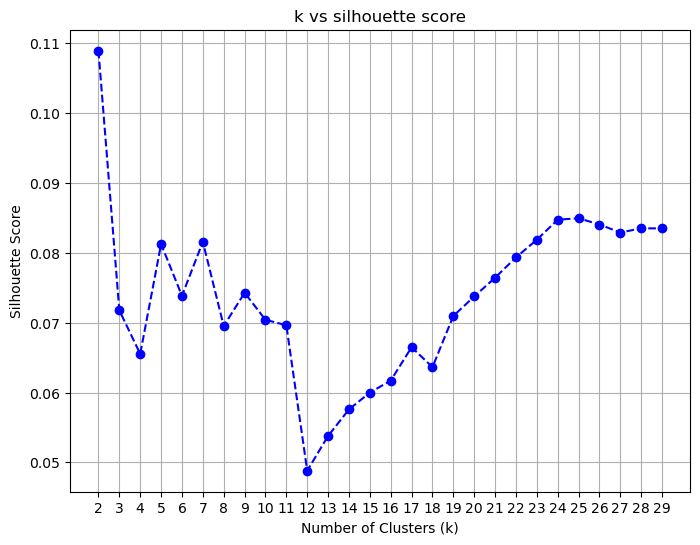

In [108]:

silhouette_scores = []
k_range = range(2, 30)

for k in k_range:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(df)

    # Calculate Silhouette Score for clustering performance
    score = silhouette_score(df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', color='b', linestyle='--')
plt.title('k vs silhouette score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 202, ncost: 672.1460953865445
Run: 1, iteration: 2/100, moves: 38, ncost: 671.4760534054152
Run: 1, iteration: 3/100, moves: 8, ncost: 671.3022168275677
Run: 1, iteration: 4/100, moves: 5, ncost: 671.2641305995023
Run: 1, iteration: 5/100, moves: 0, ncost: 671.2641305995023
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 82, ncost: 693.3911033151201
Run: 2, iteration: 2/100, moves: 59, ncost: 689.2588296857061
Run: 2, iteration: 3/100, moves: 61, ncost: 685.1032616018223
Run: 2, iteration: 4/100, moves: 77, ncost: 678.5598973473388
Run: 2, iteration: 5/100, moves: 69, ncost: 672.1464417287003
Run: 2, iteration: 6/100, moves: 22, ncost: 671.4760534054152
Run: 2, iteration: 7/100, moves: 8, ncost: 671.3022168275676
Run: 2, iteration: 8/100, moves: 5, ncost: 671.2641305995033
Run: 2, iteration: 9/100, moves: 0, nc

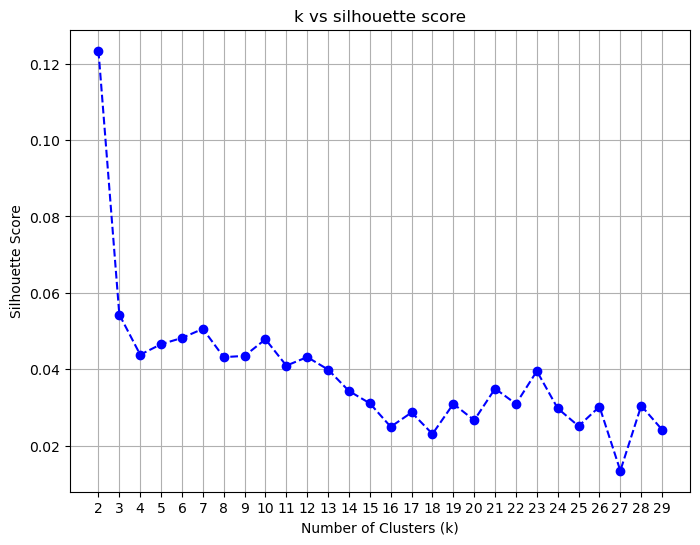

In [104]:
silhouette_scores = []
k_range = range(2, 30)  # Try k values from 2 to 10
# Indicate the indices of the categorical (binary) columns
categorical_columns = df.select_dtypes(include=['bool']).columns.tolist()
categorical_columns = [df.columns.get_loc(col) for col in categorical_columns]

for k in k_range:
    spectral = KPrototypes(n_clusters=k, init='Huang', verbose=2)
    #kproto_clusters = kproto.fit_predict(df, categorical=categorical_columns)
    labels = spectral.fit_predict(df, categorical=categorical_columns)

    # Calculate Silhouette Score for clustering performance
    score = silhouette_score(df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', color='b', linestyle='--')
plt.title('k vs silhouette score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# 3. Comparação por avaliação intrínseca

In [109]:
empirical_n_clusters = np.sqrt(len(df))/2
int(empirical_n_clusters)

#dbscan_clustering = DBSCAN(eps=2, min_samples=2).fit_predict(df)
#kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit_predict(df)
spectral_clustering = SpectralClustering(assign_labels='discretize', n_clusters=23,random_state=0).fit_predict(df)

# Initialize and fit the model
kproto = KPrototypes(n_clusters=7, init='Huang', verbose=2)
kproto_clusters = kproto.fit_predict(df, categorical=categorical_columns)

#print(silhouette_score(df,dbscan_clustering))
#print(silhouette_score(df,kmeans))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 485, ncost: 521.746699912134
Run: 1, iteration: 2/100, moves: 226, ncost: 506.2895335399602
Run: 1, iteration: 3/100, moves: 66, ncost: 505.32676588915723
Run: 1, iteration: 4/100, moves: 9, ncost: 504.9507152064214
Run: 1, iteration: 5/100, moves: 20, ncost: 503.6828203508017
Run: 1, iteration: 6/100, moves: 8, ncost: 503.6480400210346
Run: 1, iteration: 7/100, moves: 0, ncost: 503.6480400210346
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 403, ncost: 518.3216237322935
Run: 2, iteration: 2/100, moves: 65, ncost: 514.7463849465427
Run: 2, iteration: 3/100, moves: 46, ncost: 511.1352759643274
Run: 2, iteration: 4/100, moves: 21, ncost: 510.4752223537169
Run: 2, iteration: 5/100, moves: 3, ncost: 510.4529582370033
Run: 2, iteration: 6/100, moves: 0, ncost: 510.4529582370033
Init: initializing centroids
Init: i

In [110]:
print(silhouette_score(df,spectral_clustering))
print(silhouette_score(df,kproto_clusters))

0.09683917998976357
0.045590676657376344


# 4. Análise dos grupos gerados pelo melhor modelo

# 5. Outros testes